(faster_sampling_notebook)=

# Faster Sampling with JAX and Numba

:::{post} July 11, 2023
:tags: hierarchical model, JAX, numba, scaling
:category: reference, intermediate
:author: Thomas Wiecki
:::

PyMC can compile its models to various execution backends through PyTensor, including:
* C
* JAX
* Numba

By default, PyMC is using the C backend which then gets called by the Python-based samplers.

However, by compiling to other backends, we can use samplers written in other languages than Python that call the PyMC model without any Python-overhead.

For the JAX backend there is the NumPyro and BlackJAX NUTS sampler available. To use these samplers, you have to install `numpyro` and `blackjax`. Both of them are available through conda/mamba: `mamba install -c conda-forge numpyro blackjax`.

For the Numba backend, there is the [Nutpie sampler](https://github.com/pymc-devs/nutpie) writte in Rust. To use this sampler you need `nutpie` installed: `mamba install -c conda-forge nutpie`. 

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

rng = np.random.default_rng(seed=42)
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.6.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

We will use a simple probabilistic PCA model as our example.

In [3]:
def build_toy_dataset(N, D, K, sigma=1):
    x_train = np.zeros((D, N))
    w = rng.normal(
        0.0,
        2.0,
        size=(D, K),
    )
    z = rng.normal(0.0, 1.0, size=(K, N))
    mean = np.dot(w, z)
    for d in range(D):
        for n in range(N):
            x_train[d, n] = rng.normal(mean[d, n], sigma)

    print("True principal axes:")
    print(w)
    return x_train


N = 5000  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

data = build_toy_dataset(N, D, K)

True principal axes:
[[ 0.60943416]
 [-2.07996821]]


Text(0.5, 1.0, 'Simulated data set')

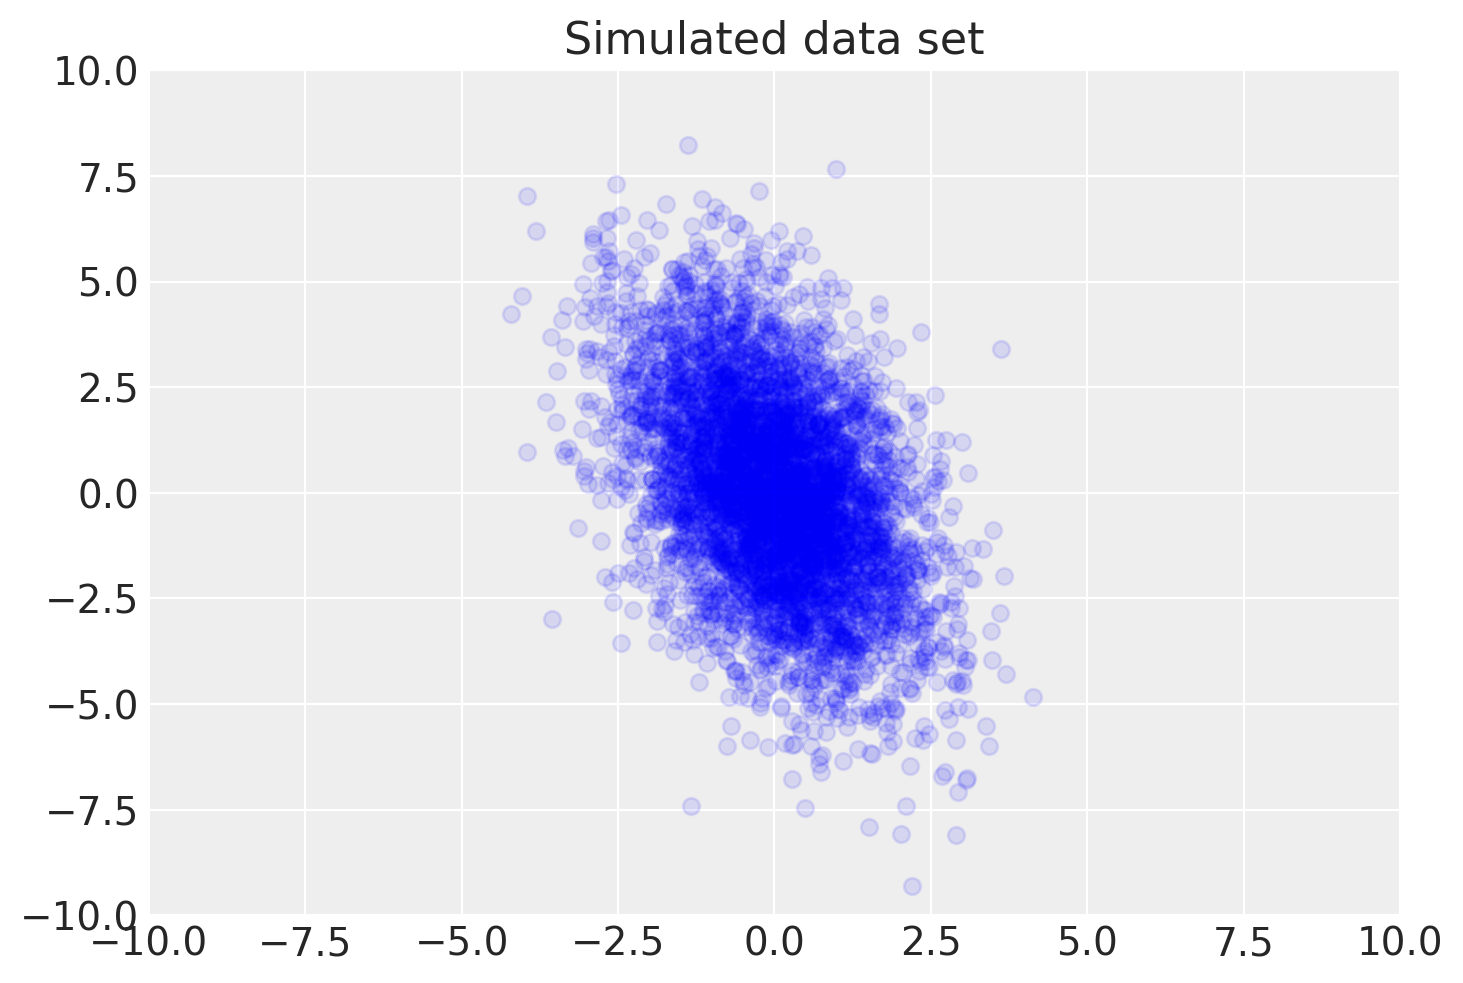

In [4]:
plt.scatter(data[0, :], data[1, :], color="blue", alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")

In [5]:
with pm.Model() as PPCA:
    w = pm.Normal("w", mu=0, sigma=2, shape=[D, K], transform=pm.distributions.transforms.Ordered())
    z = pm.Normal("z", mu=0, sigma=1, shape=[N, K])
    x = pm.Normal("x", mu=w.dot(z.T), sigma=1, shape=[D, N], observed=data)

## Sampling using Python NUTS sampler

In [6]:
%%time
with PPCA:
    idata_pymc = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
/Users/twiecki/micromamba/envs/pymc5/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


CPU times: user 19.7 s, sys: 971 ms, total: 20.7 s
Wall time: 47.6 s


## Sampling using NumPyro JAX NUTS sampler

In [7]:
%%time
with PPCA:
    idata_numpyro = pm.sample(nuts_sampler="numpyro", progressbar=False)

/Users/twiecki/micromamba/envs/pymc5/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)
/Users/twiecki/micromamba/envs/pymc5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:00.619901
Sampling...
Sampling time =  0:00:11.469112
Transforming variables...
Transformation time =  0:00:00.118111
CPU times: user 40.5 s, sys: 6.66 s, total: 47.2 s
Wall time: 12.9 s


## Sampling using BlackJAX NUTS sampler

In [8]:
%%time
with PPCA:
    idata_blackjax = pm.sample(nuts_sampler="blackjax")

/Users/twiecki/micromamba/envs/pymc5/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.607693
Sampling...
Sampling time =  0:00:02.132882
Transforming variables...
Transformation time =  0:00:08.410508
CPU times: user 35.4 s, sys: 6.73 s, total: 42.1 s
Wall time: 11.6 s


## Sampling using Nutpie Rust NUTS sampler

In [9]:
%%time
with PPCA:
    idata_nutpie = pm.sample(nuts_sampler="nutpie")

/Users/twiecki/micromamba/envs/pymc5/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)
/Users/twiecki/micromamba/envs/pymc5/lib/python3.11/site-packages/pymc/util.py:501: FutureWarning: The tag attribute observations is deprecated. Use model.rvs_to_values[rv] instead
  warnings.warn(


CPU times: user 37.6 s, sys: 3.34 s, total: 41 s
Wall time: 16.1 s


## Authors
Authored by Thomas Wiecki in July 2023

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,arviz,pymc,numpyro,blackjax,nutpie

Last updated: Tue Jul 11 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pytensor: 2.12.3
arviz   : 0.15.1
pymc    : 5.6.0
numpyro : 0.12.1
blackjax: 0.9.6
nutpie  : 0.6.0

numpy     : 1.24.4
pymc      : 5.6.0
matplotlib: 3.7.1
arviz     : 0.15.1

Watermark: 2.4.3



:::{include} ../page_footer.md
:::